In [103]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

# 1. Set up timeseries analysis

In this section, we tokenize and pre-process our documents for inputting into NLP algorithms. Our final output is a gensim corpus, which consists of a list of documents:

- Each document <i>represents</i> a tokenized, pre-processed Yelp review's text 
- Each document <i>structure</i> is a numerically-mapped token and its frequency in the document 

#### Get the data we have so far

In [272]:
df_nyt_yelp = pd.read_pickle('df_nyt_yelp.pkl')
df_reviews = pd.read_pickle('df_reviews.pkl')

#### Set up some time series

In [273]:
schedule_total = []
schedule_average_total = []
windowcount_total = []

for idx, row in df_nyt_yelp.iterrows():
    
    # get reviews for restaurant
    df = df_reviews[df_reviews['review_idx']==idx]
    
    # get dates for each time window (7-day window, beginning w/ first Yelp review)
    schedule = df.set_index('review_date').groupby(pd.Grouper(freq='7D')).mean().index.values

    # get cumulative Yelp rating average for each window
    schedule_average = []
    for s in schedule:
        window = df[df['review_date'] < s]
        schedule_average.append(window['rating'].mean())
        
    # get number of reviews written during each window
    windowcount = []
    for idx, s in enumerate(schedule):
        if idx < len(schedule)-1:
            idx2 = idx+1
            count = len(df[(df['review_date'] < schedule[idx2]) & (df['review_date'] >= s)])
            windowcount.append(count)
    
    schedule_total.append(schedule)
    schedule_average_total.append(schedule_average)
    windowcount_total.append(windowcount)

# save results by appending to master restaurant dataframe ('df_nyt_yelp')
df_nyt_yelp['window'] = schedule_total
df_nyt_yelp['window_average'] = schedule_average_total
df_nyt_yelp['window_count'] = windowcount_total
df_nyt_yelp.head()

,nyt_name,nyt_review_time,yelp_id,isclosed,yelp_rating,reviewcount,yelp_price,yelp_url,yelp_name,critics_pick,nyt_stars,window,window_average,window_count
0,Davelle,2018-06-07,PwrYnl3j3YCGzILX_5UHpw,False,4.0,47.0,2,https://www.yelp.com/biz/davelle-new-york-2,Davelle,y,NaN,"[2018-03-07T00:00:00.000000000, 2018-03-14T00:...","[nan, 5.0, 4.857142857142857, 4.77777777777777...","[4, 3, 2, 4, 4, 6, 3, 1, 2, 6, 0, 2, 2, 2, 3, 1]"
1,Lahi,2018-05-31,kDqW1eeZEDTitXerwzwCzw,False,4.0,34.0,$$,https://www.yelp.com/biz/lahi-elmhurst,Lahi,n,NaN,"[2018-04-03T00:00:00.000000000, 2018-04-10T00:...","[nan, 5.0, 4.0, 4.0, 4.0, 4.222222222222222, 4...","[1, 4, 0, 1, 3, 3, 3, 1, 0, 1, 1, 0, 0]"
2,Don Angie,2018-05-29,h37t9rA06Sr4EetJjKrfzw,False,4.5,126.0,3,https://www.yelp.com/biz/don-angie-new-york,Don Angie,y,4.0,"[2017-10-10T00:00:00.000000000, 2017-10-17T00:...","[nan, 5.0, 4.8, 4.833333333333333, 4.8, 4.8461...","[3, 2, 1, 4, 3, 1, 2, 6, 4, 4, 1, 4, 4, 5, 8, ..."
3,Rangoon Spoon,2018-05-24,chdmH_y3YReZgIlNzj8djQ,False,3.5,55.0,2,https://www.yelp.com/biz/rangoon-spoon-brooklyn,Rangoon Spoon,n,NaN,"[2017-09-24T00:00:00.000000000, 2017-10-01T00:...","[nan, 4.0, 4.0, 3.7142857142857144, 3.5, 3.315...","[1, 4, 2, 7, 5, 5, 2, 1, 2, 1, 6, 0, 1, 0, 1, ..."
4,Wokuni,2018-05-22,D6ZEcG1FCZ18nekMWrhgMg,False,4.0,60.0,3,https://www.yelp.com/biz/wokuni-new-york,Wokuni,n,3.0,"[2017-09-28T00:00:00.000000000, 2017-10-05T00:...","[nan, 5.0, 4.333333333333333, 4.5, 3.428571428...","[1, 2, 1, 3, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 0, ..."


Back up results by appending to dataframe and pickling.

In [274]:
df_nyt_yelp.to_pickle('df_nyt_yelp_pluswindows.pkl')

# 2. Examine critical time window before/after NYT review

We take the critical window period to be 6 months, where we compare the state of Yelp reviews 6 months prior to a NYT dining review and 6 months after.

## 2.1 Before/after NYT review - individual restaurant EDA

Before doing statistical hypothesis tests, we do a quick examination of the state of Yelp reviews for a restaurant, before & after the publication of NYT's review. To do so, we do some exploratory data analysis (EDA) on individual restaurants to see if time windows need to be adjusted, etc.

#### Examine two individual restaurants - one with many reviews (large), another with few reviews (small).

"Davelle" is our small restaurant w/ 47 reviews. "Tim Ho Wan" is our large restaurant w/ 1197 reviews.

In [275]:
idx1=0
df1 = df_reviews[df_reviews['review_idx']==idx1]
nyt_review_time1 = df_nyt_yelp.loc[idx1, 'nyt_review_time']
print('Restaurant info:')
df_nyt_yelp.loc[idx1]

Restaurant info:


nyt_name                                                     Davelle
nyt_review_time                                  2018-06-07 00:00:00
yelp_id                                       PwrYnl3j3YCGzILX_5UHpw
isclosed                                                       False
yelp_rating                                                        4
reviewcount                                                       47
yelp_price                                                         2
yelp_url                 https://www.yelp.com/biz/davelle-new-york-2
yelp_name                                                    Davelle
critics_pick                                                       y
nyt_stars                                                        NaN
window             [2018-03-07T00:00:00.000000000, 2018-03-14T00:...
window_average     [nan, 5.0, 4.857142857142857, 4.77777777777777...
window_count        [4, 3, 2, 4, 4, 6, 3, 1, 2, 6, 0, 2, 2, 2, 3, 1]
Name: 0, dtype: object

In [276]:
idx2=86
df2 = df_reviews[df_reviews['review_idx']==idx2]
nyt_review_time2 = df_nyt_yelp.loc[idx2, 'nyt_review_time']
print('Restaurant info:')
df_nyt_yelp.loc[idx2]

Restaurant info:


nyt_name                                                  Tim Ho Wan
nyt_review_time                                  2017-05-30 00:00:00
yelp_id                                       SyvC0s3y0ZrtnLbwnvw7tw
isclosed                                                       False
yelp_rating                                                      3.5
reviewcount                                                     1197
yelp_price                                                         2
yelp_url              https://www.yelp.com/biz/tim-ho-wan-new-york-2
yelp_name                                                 Tim Ho Wan
critics_pick                                                       y
nyt_stars                                                          3
window             [2016-12-16T00:00:00.000000000, 2016-12-23T00:...
window_average     [nan, 4.0, 3.5945945945945947, 3.3893805309734...
window_count       [36, 38, 39, 28, 22, 21, 12, 22, 23, 23, 21, 2...
Name: 86, dtype: object

#### Examine "before" & "after" w/ 6 month time window

Examine Yelp reviews 6 months before and after its NYT review publication.

In [283]:
from datetime import datetime, timedelta

# get 6 months before NYT review, 6 months after
before_time1 = nyt_review_time1 - timedelta(days=180)
after_time1 = nyt_review_time1 + timedelta(days=180)

# grab reviews before/after NYT review publication
before_nyt1 = df1[(df1['review_date'] >= before_time1) & (df1['review_date'] < nyt_review_time1)]
after_nyt1 = df1[(df1['review_date'] > nyt_review_time1) & (df1['review_date'] <= after_time1)]

# generate indices of "before"/"after" reviews
before_nyt_idx1 = before_nyt1.index.values.tolist()
after_nyt_idx1 = after_nyt1.index.values.tolist()

before_nyt_mean1 = before_nyt1['rating'].mean()
after_nyt_mean1 = after_nyt1['rating'].mean()

print('Davelle (47 reviews):')
print('Average Yelp rating 6 months before NYT review: ', before_nyt_mean1)
print('Average Yelp rating 6 months after NYT review: ', after_nyt_mean1, '\n')

# get 6 months before NYT review, 6 months after
before_time2 = nyt_review_time2 - timedelta(days=90)
after_time2 = nyt_review_time2 + timedelta(days=90)

# grab reviews before/after NYT review publication
before_nyt2 = df2[(df2['review_date'] >= before_time2) & (df2['review_date'] < nyt_review_time2)]
after_nyt2 = df2[(df2['review_date'] > nyt_review_time2) & (df2['review_date'] <= after_time2)]

# generate indices of "before"/"after" reviews
before_nyt_idx2 = before_nyt2.index.values.tolist()
after_nyt_idx2 = after_nyt2.index.values.tolist()

before_nyt_mean2 = before_nyt2['rating'].mean()
after_nyt_mean2 = after_nyt2['rating'].mean()

print('Tim Ho Wan (1197 reviews):')
print('Average Yelp rating 6 months before NYT review: ', before_nyt_mean2)
print('Average Yelp rating 6 months after NYT review: ', after_nyt_mean2)

Davelle (47 reviews):
Average Yelp rating 6 months before NYT review:  4.333333333333333
Average Yelp rating 6 months after NYT review:  3.5 

Tim Ho Wan (1197 reviews):
Average Yelp rating 6 months before NYT review:  3.326771653543307
Average Yelp rating 6 months after NYT review:  3.570588235294118


Since Davelle only has 47 Yelp reviews, and the NYT review was only recently published in June 2018, the lack of reviews may be exaggerating the "before"/"after" difference. We proceed with examining Yelp reviews before/after NYT review <i>without</i> any time window to see if the difference changes.

#### Examine "before" & "after" w/ no time window

Examine Yelp rating before & after NYT review publication, with no restriction of time window size for "before"/"after" NYT review (i.e. all reviews, not just within 6 months, before/after NYT review)

In [278]:
before_nyt_nowindow1 = df1[df1['review_date'] <= nyt_review_time1]
after_nyt_nowindow1 = df1[df1['review_date'] > nyt_review_time1]

before_nyt_nowindow2 = df2[df2['review_date'] <= nyt_review_time2]
after_nyt_nowindow2 = df2[df2['review_date'] > nyt_review_time2]

print('Davelle (47 reviews):')
print('Average Yelp rating before NYT review: ', before_nyt_nowindow1['rating'].mean())
print('Average Yelp rating after NYT review: ', after_nyt_nowindow1['rating'].mean(), '\n')

print('Tim Ho Wan (1197 reviews):')
print('Average Yelp rating before NYT review: ', before_nyt_nowindow2['rating'].mean())
print('Average Yelp rating after NYT review: ', after_nyt_nowindow2['rating'].mean())

Davelle (47 reviews):
Average Yelp rating before NYT review:  4.333333333333333
Average Yelp rating after NYT review:  3.5 

Tim Ho Wan (1197 reviews):
Average Yelp rating before NYT review:  3.35195530726257
Average Yelp rating after NYT review:  3.553544494720965


Not a huge difference, so we might stick with the 6-month window. The rationale is that if we don't restrict the time window after a NYT review, there could be years' worth of Yelp reviews after a NYT review is published, where such subsequent Yelp reviews may have nothing to do with the NYT review.

# 3. Bootstrapping analysis - Yelp ratings

Here, we bootstrap our data to form a null distribution of our data. Then we calculate p-value to determine how likely our actual sample mean would appear under the bootstrapped "null distribution". Rejecting the null hypothesis would support a NYT review affecting the restaurant's subsequent Yelp ratings.

#### Define some functions

We use bootstrap sampling from our current "population" of reviews to form a null distribution. By drawing randomly from our reviews, we form a distribution in which the reviews are randomly included irrespective of whether they occurrred before or after a NYT review - hence, a "null hypothesis" distribution where the population is under the assumption that there is no difference between the "before"/"after" NYT reviews.

Our test statistic is the overall <i>mean</i> Yelp rating. That means we have:
- A function that draws observations randomly from our population (a bootstrapped replicate)
- Another function that extracts the mean of the boostrapped replicate and repeats the process many times (here, set to 1000 times by default) to obtain a distribution of 1000 sample means (the null distribution).

In [279]:
# Bootstrap replicate function

def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample) 

# Function that draws multiple bootstrap replicates

def draw_bs_reps(data, func, size=1000):

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

## 3.1 Bootstrapping: all data up to 6 months post-NYT

We begin by bootstrapping the overall data for our restaurant example from the previous section. The idea is that the resulting distribution of sample means operates under the assumption that the NYT review never had an effect on the overall Yelp rating (within 6 months post-review, the time window we set for a NYT effect). 

This means that:
- The null distribution is formed by sampling randomly from all Yelp reviews, irrespective of whether they occurred before/after the NYT review.
- Our actual sample statistic (that we will be calculating p-value on) is the restaurant's overall Yelp average, 6 months after  the NYT review.

So:
- H0: A restaurant's NYT review had no effect on the restaurant's average Yelp rating, within 6 months after publication.
- HA: A restaurant's NYT review <i>had</i> an effect on the restaurant's average Yelp rating, within 6 months after publication.

### 3.1.1 Test our bootstrapping process with our previous restaurant example.

In [280]:
# draw bootstrap samples

bs_replicates1 = draw_bs_reps(df1['rating'], np.mean, size=1000) # for small restaurant
bs_replicates2 = draw_bs_reps(df2['rating'], np.mean, size=1000) # for large restaurant

#### Visualize null distribution of sample means (Yelp average)
Visualize the simulated/bootstrapped distribution for the null hypothesis, where the sample means are generated from bootstrapped replicates drawn randomly irrespective of whether it was before/after the NYT review. 

Davelle (47 reviews):
Hypothetical Yelp average:  4.192361702127659
Our Yelp average:  4.191489361702128 

Tim Ho Wan (1197 reviews):
Hypothetical Yelp average:  3.465124166666667
Our Yelp average:  3.4045261669024045


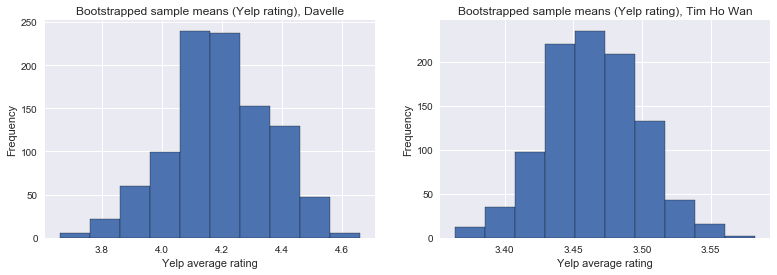

In [281]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

# for small restaurant

mean_null1 = bs_replicates1.mean()
mean_actual1 = df1[df1['review_date'] <= after_time1]['rating'].mean()

ax1.hist(bs_replicates1);
ax1.set(xlabel='Yelp average rating', ylabel='Frequency', title='Bootstrapped sample means (Yelp rating), Davelle')

print('Davelle (47 reviews):')
print('Hypothetical Yelp average: ', mean_null1)
print('Our Yelp average: ', mean_actual1, '\n')

# for large restaurant

mean_null2 = bs_replicates2.mean()
mean_actual2 = df2[df2['review_date'] <= after_time2]['rating'].mean()

ax2.hist(bs_replicates2);
ax2.set(xlabel='Yelp average rating', ylabel='Frequency', title='Bootstrapped sample means (Yelp rating), Tim Ho Wan')

print('Tim Ho Wan (1197 reviews):')
print('Hypothetical Yelp average: ', mean_null2)
print('Our Yelp average: ', mean_actual2)

The data has a fairly normal distribution, which is a good sign as this allows us to calculate a p-value under the normal assumption.

#### Statistical test

We calculate the p-value, which is how likely we would get our actual observed sample mean (restaurant's Yelp average 6 months after NYT review) under the null distribution. 

In [282]:
p1 = np.sum( bs_replicates1 >= mean_actual1 ) / len(bs_replicates1)
p2 = np.sum( bs_replicates2 <= mean_actual2 ) / len(bs_replicates2)

print('Davelle (small restaurant) p-value: ', p1)
print('Tim Ho Wan (large restaurant) p-value: ', p2)

Davelle (small restaurant) p-value:  0.528
Tim Ho Wan (large restaurant) p-value:  0.034


The p-value isn't significant for Davelle, which means we <i><b>cannot</b></i> reject our null hypothesis that the NYT review made no difference to the Yelp average (within 6 months). However, "Tim Ho Wan"'s p-value is significant (${\alpha}$=0.05), perhaps because it has much more reviews (both pre- & post-NYT review).

### 3.1.2 Discussion

<b>Washing out effect</b>: Although our p-values weren't significant, the way in which we calculated our "actual observed" test statistic, Yelp average rating, may be faulty. Here, we've considered it to be based on the average Yelp rating 6 months after a restaurant's NYT dining review was published (~<b>4.19</b> for "Davelle"). However, this average incorporates Yelp reviews written <i>before</i> the NYT review (pre-NYT), which may wash out any effect that changes to Yelp reviews post-NYT could have had.

<b>Solution</b>: If we considered instead the average Yelp rating from Yelp reviews beginning with the NYT review publication and 6 months later (i.e. restricted the window for calculating our Yelp average), we may have a different story. In this case, our Yelp average would be ~<b>3.5</b> for "Davelle", for instance. We explore this in the next section.

To summarize, the pros/cons of our approach in this section are:

- <b>Pros</b>: More data - our test statistic is based on the Yelp average of <i>all reviews up to 6 months after NYT review publication</i>. The alternative would be to calculate the Yelp average based <i>only</i> on Yelp reviews written <i>after</i> the NYT review (within 6 months), which could considerably reduce our dataset if we're already dealing w/ a restaurant with <100 reviews.

- <b>Cons</b>: Particularly for small datasets or restaurants with recent NYT reviews, any effect of a NYT review may be lost as our test statistic is based on Yelp rating average derived from <i>both</b> pre- and post-NYT review Yelp reviews</i>. A stronger effect, for instance, could be found if we only compared Yelp averages calculated before <i>vs.</i> after NYT review.

## 3.2 Bootstrapping: only 6 months post-NYT

Following up from the previous discussion, we now conduct a statistical test using new criteria for our actual Yelp average. In this case, the Yelp average is calculated from Yelp reviews only written <i><b>after</b></i> the NYT review went live (and up to 6 months after NYT review). 

The way we bootstrap the data to form our null distribution remains the same, except that rather than drawing from all Yelp reviews in the history of the restaurant, we draw up to 6 months post-NYT review.

In [284]:
# draw bootstrap samples

data1 = df1[df1['review_date'] <= after_time1]['rating']
data2 = df2[df2['review_date'] <= after_time2]['rating']

bs_replicates1_restricted = draw_bs_reps(data1, np.mean, size=1000) # for small restaurant
bs_replicates2_restricted = draw_bs_reps(data2, np.mean, size=1000) # for large restaurant

print('Davelle, null dist mean: ', bs_replicates1_restricted.mean())
print('Tim Ho Wan, null dist mean: ', bs_replicates2_restricted.mean(),'\n')

mean_actual_restricted1 = df1[(df1['review_date'] <= after_time1) & (df1['review_date'] > nyt_review_time1)]['rating'].mean()
mean_actual_restricted2  = df2[(df2['review_date'] <= after_time2) & (df2['review_date'] > nyt_review_time2)]['rating'].mean()

print('Davelle, actual mean: ', mean_actual_restricted1)
print('Tim Ho Wan, actual mean: ', mean_actual_restricted2)

Davelle, null dist mean:  4.192106382978723
Tim Ho Wan, null dist mean:  3.4028429985855726 

Davelle, actual mean:  3.5
Tim Ho Wan, actual mean:  3.570588235294118


In [285]:
p1 = np.sum(bs_replicates1 <= mean_actual_restricted1) / len(bs_replicates1)
p2 = np.sum(bs_replicates2 >= mean_actual_restricted2) / len(bs_replicates2)

print('Davelle (small restaurant) p-value: ', p1)
print('Tim Ho Wan (large restaurant) p-value: ', p2)

Davelle (small restaurant) p-value:  0.0
Tim Ho Wan (large restaurant) p-value:  0.001


The p-value is now significant (< 0.01), which means we <i><b>reject</b></i> our null hypothesis. Our observed Yelp average is too unlikely under the assumption that the null hypothesis is true, which means there is sufficient evidence that the post-NYT Yelp average is different from pre-NYT average. This result would support the possibility that the NYT review could have impacted Yelp ratings).

### Discussion

<b>NYT review impact</b>: By taking as our post-NYT Yelp average to only include reviews during the 6 month period following NYT review publication (as opposed to including reviews leading up to NYT review publication as well), we now are able to support the idea that NYT reviews impact Yelp ratings.

<b>P-value caution</b>: However, we should keep in mind that the p-values are suspiciously low. This is likely due to the fact that since we restricted our window for calculating post-NYT reviews to just 6 months, this average will almost always deviate highly from the overall Yelp average from which we obtained our bootstrapped null distribution.

To alleviate our concerns about inflated p-value, we increase our review size by including <i><b>all</b></i> reviews post-NYT to see if the effect washes out.

## 3.3 Bootstrapping: all data before/after NYT

In the previous section, we saw that the statistical significance of our p-value was likely inflated by the much fewer reviews available to average during the 6 month window post-NYT review publication. Here, we ignore this window and take as our Yelp average all reviews post-NYT (i.e. no 6-month restriction, but up until most recent review).

In [287]:
# draw bootstrap samples

data1_unrestricted = df1['rating']
data2_unrestricted = df2['rating']

bs_replicates1_unrestricted = draw_bs_reps(data1_unrestricted, np.mean, size=1000) # for small restaurant
bs_replicates2_unrestricted = draw_bs_reps(data2_unrestricted, np.mean, size=1000) # for large restaurant

print('Davelle, null dist mean: ', bs_replicates1_unrestricted.mean())
print('Tim Ho Wan, null dist mean: ', bs_replicates2_unrestricted.mean(),'\n')

actual_unrestricted1 = df1[df1['review_date'] > nyt_review_time1]['rating']
actual_unrestricted2 = df2[df2['review_date'] > nyt_review_time2]['rating']

mean_actual_unrestricted1 = df1[df1['review_date'] > nyt_review_time1]['rating'].mean()
mean_actual_unrestricted2  = df2[df2['review_date'] > nyt_review_time2]['rating'].mean()

print('Davelle, actual mean: ', mean_actual_unrestricted1)
print('Tim Ho Wan, actual mean: ', mean_actual_unrestricted2)

Davelle, null dist mean:  4.191765957446809
Tim Ho Wan, null dist mean:  3.4617733333333334 

Davelle, actual mean:  3.5
Tim Ho Wan, actual mean:  3.553544494720965


In [288]:
p1 = np.sum(bs_replicates1_unrestricted <= mean_actual_unrestricted1) / len(bs_replicates1_unrestricted)
p2 = np.sum(bs_replicates2_unrestricted >= mean_actual_unrestricted2) / len(bs_replicates2_unrestricted)

print('Davelle (small restaurant) p-value: ', p1)
print('Tim Ho Wan (large restaurant) p-value: ', p2)

Davelle (small restaurant) p-value:  0.0
Tim Ho Wan (large restaurant) p-value:  0.004


For final measure, we compute how large our subset vs. total set of reviews are.

In [289]:
print('Davelle: ')
print('Bootstrapped set: ', len(data1_unrestricted), 'reviews')
print('Test subset: ', len(actual_unrestricted1), 'reviews''\n')

print('Tim Ho Wan: ')
print('Bootstrapped set: ', len(data2_unrestricted), 'reviews')
print('Test subset: ', len(actual_unrestricted2), 'reviews')

Davelle: 
Bootstrapped set:  47 reviews
Test subset:  8 reviews

Tim Ho Wan: 
Bootstrapped set:  1200 reviews
Test subset:  663 reviews


Davelle's test subset is much smaller than the larger, complete corpus of reviews. However, "Tim Ho Wan"'s subset represents a much larger fraction of all reviews (a little over 50%) and its p-value is still very significant.

### Discussion

Our p-value increased slightly for at least one of our restaurants. However, they remain firmly statistically significant. 

<b>Subset vs. total set Yelp averages</b>: Inevitably, the sample mean we calculate for our actual pool of Yelp reviews (everything post-NYT review) is smaller than the review pool we draw from for bootstrapping our null distribution (all Yelp reviews in the history of the restaurant). This difference means that it is possible our p-values are still inflated because averaging over a subset of reviews increases the chance that this average will deviate more from an average over the larger, complete corpus of reviews.

<b>Conclusion</b>: 
- <b>Low p-values</b>: Although it would be ideal to work with larger review sizes, we are restricted to a diverse set of both small and large restaurants. Regardless, our p-values are still so low that it could be likely that it will remain statistically significant even if we used larger sample sizes.

- <b>Automating statistical testing</b>: We will take the statistical test/bootstrapping process from 3.3 (the previous section) to automate the process of discovering whether a NYT review has impacted a restaurant's Yelp reviews. The rationale is that this is the more conservative of the two techniques we used to determine post-NYT impact.

# 4. An algorithm for bootstrapping all restaurants - Yelp rating

In the previous section, we conducted EDA on two specific restaurant examples to steer us towards the appropriate statistical test/bootstrapping process. Here, we automate the process to all restaurants.

## 4.1 Conduct statistical test/bootstrapping on each restaurant

In [290]:
pvals_total = []
beforenyt_total = []
afternyt_total = []

for idx, row in df_nyt_yelp.loc[:280].iterrows():
    
    # get reviews for restaurant
    df = df_reviews[df_reviews['review_idx']==idx]
    nyt_review_time = df_nyt_yelp.loc[idx, 'nyt_review_time']
    after_time = nyt_review_time + timedelta(days=180)
    
    # bootstrap replicates to get 1000 sample means (average Yelp ratings)
    bs_replicates = draw_bs_reps(df['rating'], np.mean, size=1000) # for small restaurant
    #bs_replicates = draw_bs_reps(df[df['review_date'] <= after_time]['rating'], np.mean, size=1000)
    mean_null = bs_replicates.mean()
    
    # get actual Yelp average
    mean_actual = df[df['review_date'] <= after_time]['rating'].mean()
    
    # get p-value
    if mean_actual < mean_null:
        p = np.sum(bs_replicates <= mean_actual) / len(bs_replicates)
    else:
        p = np.sum(bs_replicates >= mean_actual) / len(bs_replicates)
    
    # get before & after averages
    mean_before = df[df['review_date'] <= nyt_review_time]['rating'].mean()
    mean_after = df[df['review_date'] > nyt_review_time]['rating'].mean()
    
    # save p-value
    pvals_total.append(p)
    beforenyt_total.append(mean_before)
    afternyt_total.append(mean_after)

c:\users\diana\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal


#### Combine results with Yelp & NYT info.

In [291]:
df_influence = pd.DataFrame({'nyt_name':df_nyt_yelp.loc[:280]['nyt_name'],
              'nyt_review_time':df_nyt_yelp.loc[:280]['nyt_review_time'],
              'critics_pick':df_nyt_yelp.loc[:280]['critics_pick'],
              'nyt_stars':df_nyt_yelp.loc[:280]['nyt_stars'],
              'yelp_rating':df_nyt_yelp.loc[:280]['yelp_rating'],
              'reviewcount':df_nyt_yelp.loc[:280]['reviewcount'],
              'pval':pvals_total,
              'mean_before':beforenyt_total,
              'mean_after':afternyt_total})
df_influence.head()

,critics_pick,mean_after,mean_before,nyt_name,nyt_review_time,nyt_stars,pval,reviewcount,yelp_rating
0,y,3.500000,4.333333,Davelle,2018-06-07,NaN,0.490,47.0,4.0
1,n,4.250000,4.125000,Lahi,2018-05-31,NaN,0.529,34.0,4.0
2,y,4.809524,4.603774,Don Angie,2018-05-29,4.0,0.508,126.0,4.5
3,n,3.500000,3.448980,Rangoon Spoon,2018-05-24,NaN,0.512,55.0,3.5
4,n,3.666667,3.848485,Wokuni,2018-05-22,3.0,0.510,60.0,4.0


## 4.2 Inspect results

#### P-values: significant vs. insignificant

In [294]:
df_insig = df_influence[df_influence['pval'] > 0.05]
df_sig = df_influence[df_influence['pval'] <= 0.05]

pval_insig = df_insig.index.values.tolist()
pval_sig = df_sig.index.values.tolist()

print('Number of restaurants w/ insignificant p-values: ', len(pval_insig))
print('Number of restaurants w/ significant p-values: ', len(pval_sig))

Number of restaurants w/ insignificant p-values:  210
Number of restaurants w/ significant p-values:  67


About 43% of all our restaurants have insignificant p-values, which means our statistical test/bootstrap process inferred that NYT reviews did not have an effect on these restaurants' ratings.

#### Reviewcount, average rating

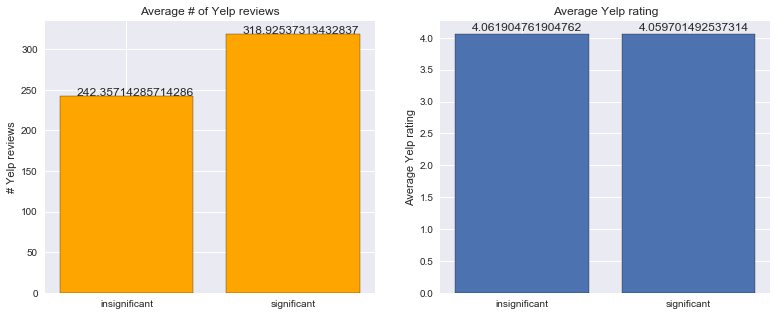

In [314]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# reviewcount
count_insig = df_insig['reviewcount'].mean()
count_sig = df_sig['reviewcount'].mean()
ax1.bar(['insignificant', 'significant'], [count_insig, count_sig], color='orange')
ax1.set(ylabel='# Yelp reviews', title='Average # of Yelp reviews');
for p1, label1 in zip(ax1.patches, [count_insig, count_sig]):
    ax1.annotate(label1, (p1.get_x()+0.1, p1.get_height()+0.2))

# average Yelp rating
rating_insig = df_insig['yelp_rating'].mean()
rating_sig = df_sig['yelp_rating'].mean()
ax2.bar(['insignificant', 'significant'], [rating_insig, rating_sig]);
ax2.set(ylabel='Average Yelp rating', title='Average Yelp rating');
for p2, label2 in zip(ax2.patches, [rating_insig, rating_sig]):
    ax2.annotate(label2, (p2.get_x()+0.1, p2.get_height()-.15+0.2))

Average rating does not actually differ by much between the insigificant and significant restaurants. In fact, significant restaurants have slightly lower average Yelp rating. 

#### Do "NYT Critic's Pick" & NYT stars affect Yelp ratings?

From our `data_vis` notebook exploring the meaning behind the "NYT Critic's Pick" label, we would not expect much of an effect of this label on Yelp rating outcome. However, we still see that our "significant" restaurants (i.e. restaurants w/ statistically significant p-values supporting effect of NYT review on ratings) have a lower rate of "Critic's Pick" awarded. This difference may also be due to the fact that there are much fewer "significant" restaurants.

% "Critic"s Pick ("insignificant" restaurants):  0.7
% "Critic"s Pick ("significant" restaurants):  0.6268656716417911 

% NYT stars ("insignificant" restaurants):  0.5
% NYT stars ("significant" restaurants):  0.11428571428571428


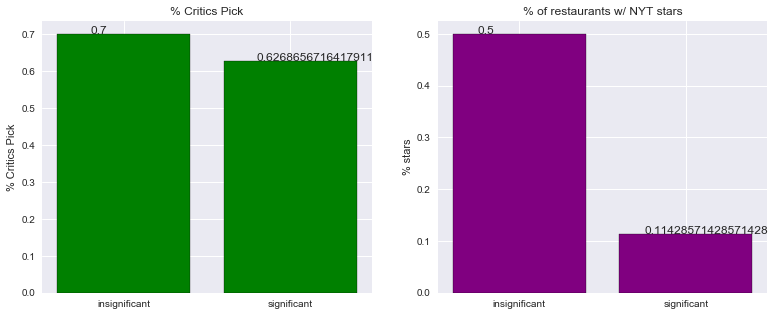

In [337]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# critics pick
pick_insig = len(df_insig[df_insig['critics_pick']=='y']) / len(pval_insig)
pick_sig = len(df_sig[df_sig['critics_pick']=='y']) / len(pval_sig)
ax1.bar(['insignificant', 'significant'], [pick_insig, pick_sig], color='green')
ax1.set(ylabel='% Critics Pick', title='% Critics Pick');
for p1, label1 in zip(ax1.patches, [pick_insig, pick_sig]):
    ax1.annotate(label1, (p1.get_x()+.2, p1.get_height()))

# nyt stars
stars_insig = len(df_insig[df_insig['nyt_stars'].isnull()==False]) / len(df_insig)
stars_sig = len(df_sig[df_sig['nyt_stars'].isnull()==False]) / len(df_insig)
ax2.bar(['insignificant', 'significant'], [stars_insig, stars_sig], color='purple');
ax2.set(ylabel='% stars', title='% of restaurants w/ NYT stars');
for p2, label2 in zip(ax2.patches, [stars_insig, stars_sig]):
    ax2.annotate(label2, (p2.get_x()+.15, p2.get_height()))
    
print('% "Critic"s Pick ("insignificant" restaurants): ', pick_insig)
print('% "Critic"s Pick ("significant" restaurants): ', pick_sig,'\n')

print('% NYT stars ("insignificant" restaurants): ', stars_insig)
print('% NYT stars ("significant" restaurants): ', stars_sig)

Counterintuitively, with significant restaurants we actually get fewer % "Critic's Pick" and NYT stars. 

However, there still were ~25 restaurants that did have a significant change in their average Yelp rating before vs. after their NYT review. This suggests that NYT review impact may vary on a case-by-case basis, dependent upon other factors we did not take into account such location/accessibility, whether the NYT review made it more likely for other media outlets to pick up on the restaurant, number of pre-existing customers, and many other factors that affect a restaurant's business.

## 4.3 Discussion

In this section, we:
- Successfully set up a pipeline for a statistical testing/bootstrapping algorithm that parses restaurants that were probably significantly impacted by their NYT review ("significant" restaurants). 
- Found that that having "Critic's Pick" or NYT stars does not guarantee that Yelp rating will be affected, and that such an effect probably varies on a case-by-case basis dependent upon other factors.

However, we still need to examine restaurant "popularity". Although NYT review impact may not necessarily generalize to Yelp ratings, we may still see an effect on number of Yelp reviews written (which reflects # of customers).

# 5. The impact of NYT reviews on restaurant popularity

Up until now, we have only examined Yelp ratings. Now we examine the possible impact of NYT reviews on restaurant popularity, where popularity is measured by the number of reviews written for a restaurant on Yelp.

In [390]:
beforecount_total = []
aftercount_total = []

for idx, row in df_nyt_yelp.loc[:280].iterrows():
    
    # get reviews for restaurant
    df = df_reviews[df_reviews['review_idx']==idx]
    nyt_review_time = df_nyt_yelp.loc[idx, 'nyt_review_time']
    
    # get time windows
    after_time = nyt_review_time + timedelta(days=180) # 6-month time window cap post-NYT review
    before_time = nyt_review_time - timedelta(days=180) # 6-month time window cap pre-NYT review
    
    # review count per-month before/after NYT review (6-mo window)
    before_count = len(df[(df['review_date'] <= nyt_review_time) & (df['review_date'] >= before_time)]) / 6
    after_count = len(df[(df['review_date'] > nyt_review_time) & (df['review_date'] <= after_time)]) / 6
    
    # save p-value
    beforecount_total.append(before_count)
    aftercount_total.append(after_count)

# append results to 'df_influence' dataframe
df_influence['count_before'] = beforecount_total
df_influence['count_after'] = aftercount_total
df_influence['count_difference'] = [aftercount_total - beforecount_total for aftercount_total, beforecount_total in zip(aftercount_total, beforecount_total)]

#### The difference between pre- & post-NYT publication review count.

Average difference:  1.3375451263537903 reviews per month


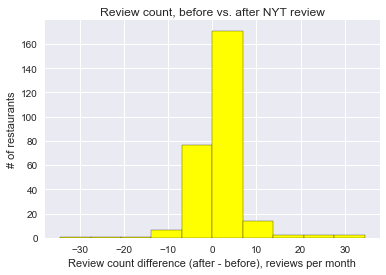

In [391]:
plt.hist(df_influence['count_difference'], color='yellow');
plt.xlabel('Review count difference (after - before), reviews per month');
plt.ylabel('# of restaurants');
plt.title('Review count, before vs. after NYT review');
print('Average difference: ', sum(count_difference)/len(count_difference),'reviews per month')

The distribution of review count differences seems centered around 0. However, there are clearly some restaurants that have a significant popularity difference before vs. after their NYT review was published. 

Since the difference distribution is conveniently centered around 0, we can therefore take the extreme differences (>2 standard deviations from mean) below & above average to be restaurants that have a significant change in popularity post-NYT review, as if we had just gone through the process of conducting a statistical hypothesis test and generated a null distribution. We do this in the following section.

#### Restaurants w/ significant popularity changes

In [393]:
from scipy.stats import norm

# Fit a normal distribution to the data
mu, std = norm.fit(count_difference) 
print('Mean: ', mu)
print('Standard deviation: ', std)

# take values >2 standard deviations to be "significant"
high = mu + 2*std
low = mu - 2*std

# find "significant" restaurants
df_influence[(df_influence['count_difference'] >= high)| (df_influence['count_difference'] <= low)]

Mean:  1.3375451263537905
Standard deviation:  5.699353795368973


,critics_pick,mean_after,mean_before,nyt_name,nyt_review_time,nyt_stars,pval,reviewcount,yelp_rating,count_before,count_after,count_difference
2,y,4.809524,4.603774,Don Angie,2018-05-29,4.0,0.508,126.0,4.5,15.000000,3.500000,-11.500000
5,y,3.785714,3.945652,Em,2018-05-17,NaN,0.521,118.0,4.0,15.333333,4.666667,-10.666667
17,n,3.503876,2.672862,DaDong,2018-03-06,2.0,0.475,392.0,3.0,44.833333,21.500000,-23.333333
43,y,4.000000,3.777778,Cote,2017-11-14,4.0,0.255,390.0,4.0,16.500000,38.666667,22.166667
86,y,3.553544,3.351955,Tim Ho Wan,2017-05-30,3.0,0.135,1197.0,3.5,89.500000,55.000000,-34.500000
129,n,4.433548,4.336000,Thursday Kitchen,2016-11-16,NaN,0.299,899.0,4.5,20.833333,41.500000,20.666667
130,y,3.963603,3.919255,TsuruTonTan Udon Noodle Brasserie,2016-11-16,3.0,0.000,1236.0,4.0,26.833333,61.333333,34.500000
135,n,4.017595,4.411765,Sushi on Jones,2016-10-26,NaN,0.000,370.0,4.0,5.666667,19.333333,13.666667
145,n,4.198370,4.338983,2nd City,2016-09-21,NaN,0.018,545.0,4.0,29.500000,17.666667,-11.833333
203,n,4.296167,4.526882,Sons of Thunder,2016-02-10,NaN,0.034,664.0,4.5,15.500000,39.333333,23.833333


We don't have a lot of data to work with, so doing further statistical tests might not be particularly useful. We can see the types of restaurants (whether they have "Critic's Pick", NYT stars, etc) is a mixed bag - there's not really anything that stands out as a contributer to whether a restaurant's popularity is affected by its NYT review.

Following up from our findings from our Yelp rating analysis, these results continue the trend of "NYT affects Yelp stats on a case-by-case basis".